In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
app =  pd.read_csv('../data/application_train.csv')[['SK_ID_CURR','TARGET']]
# credit_card_balance =  pd.read_csv('../data/credit_card_balance.csv')[['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']]
POS_CASH_balance =  pd.read_csv('../data/POS_CASH_balance.csv')
installments_payments =  pd.read_csv('../data/installments_payments.csv')

installments_payments['MONTHS_BALANCE'] = (installments_payments['DAYS_INSTALMENT']/30).round().astype(int)

In [3]:
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA
0,1803195,182943,-31,48.0,45.0,0,0,1,0,0,0,0,0,0,0,0
1,1715348,367990,-33,36.0,35.0,0,0,1,0,0,0,0,0,0,0,0
2,1784872,397406,-32,12.0,9.0,0,0,1,0,0,0,0,0,0,0,0
3,1903291,269225,-35,48.0,42.0,0,0,1,0,0,0,0,0,0,0,0
4,2341044,334279,-35,36.0,35.0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,843,0,1,0,0,0,0,0,0,0,0
10001354,1717234,141565,-19,12.0,0.0,602,0,1,0,0,0,0,0,0,0,0
10001355,1283126,315695,-21,10.0,0.0,609,0,1,0,0,0,0,0,0,0,0
10001356,1082516,450255,-22,12.0,0.0,614,0,1,0,0,0,0,0,0,0,0


## Resampling imbalance

Random under-sampling:
0    24825
1    24825
Name: TARGET, dtype: int64


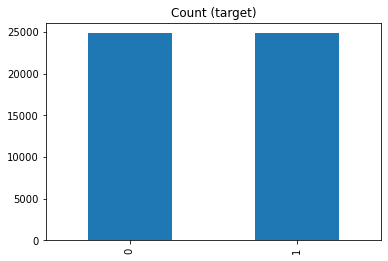

In [3]:
count_class_0, count_class_1 = app.TARGET.value_counts()
df_class_0 = app[app['TARGET'] == 0]
df_class_1 = app[app['TARGET'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
app = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(app.TARGET.value_counts())

app.TARGET.value_counts().plot(kind='bar', title='Count (target)');

## Merge time series DFS

In [ ]:
df = pd.merge(app,pd.merge(installments_payments, POS_CASH_balance , how='left'),how='inner')
df = df[df['MONTHS_BALANCE']>-80]

## Fillna(mean)

In [ ]:
df = df.fillna(df.mean)




## Select features with most corr with TARGET

In [ ]:
main_features = df.groupby('SK_ID_CURR').mean().corr()['TARGET'].abs().sort_values(ascending=False)[1:6].keys()
main_features=main_features.drop('MONTHS_BALANCE')
main_features

In [ ]:
dlkmp

## Normalize df

In [ ]:
del POS_CASH_balance ,installments_payments, app
gc.collect()

In [ ]:
df.shape

## Pivot on months

In [ ]:
df_pivot = df.pivot_table(values=main_features, index=['SK_ID_CURR'], columns='MONTHS_BALANCE')

In [ ]:
df_pivot= df_pivot.fillna(0)

In [ ]:
y = df[['SK_ID_CURR','TARGET']].groupby('SK_ID_CURR').mean()

In [ ]:

x = df_pivot.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_pivot = pd.DataFrame(x_scaled)

In [ ]:
df_pivot.to_csv('../treated_data/pivoted_x.csv',index=False )
y.to_csv('../treated_data/pivoted_y.csv')

In [ ]:
x = df_pivot.values.reshape((46793,80,4))

# MODEL

In [ ]:
# df_pivot = pd.read_csv('../treated_data/pivoted_x.csv')
# y = pd.read_csv('../treated_data/pivoted_y.csv')
# rehape


In [ ]:
df_pivot

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(42, return_sequences = True),
    tf.keras.layers.LSTM(20, return_sequences = False),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics='accuracy')

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs= 100, batch_size=200, validation_data=(X_test,y_test) )

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.predict(X_test).mean()